In [10]:
import preprocessors
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_tree

In [3]:
myLoader = preprocessors.Loader("C:/Users/emily/Documents/DissertationProject/training/training_setA_csv")
hospital_df = myLoader.get_flat_df()
hospital_df.head()

In [11]:
#pickle
#hospital_df.to_pickle("hospitalA_df_flat.pkl")
hospital_df = pd.read_pickle("C:/Users/emily/Documents/DissertationProject/pickles/hospitalA_df_flat.pkl")

# Feature Importance for SepsisLabel

In [12]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

df = hospital_df.copy() 
target = "SepsisLabel"
features = [col for col in df.columns if col != target]  # Use all columns except target

df[features] = df.groupby("Patient_ID")[features].ffill().bfill()
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = xgb.XGBClassifier(eval_metric="logloss", max_depth=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC Score: {auc:.4f}")
#precision
#recall


Accuracy: 0.9955
AUC-ROC Score: 0.9989


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

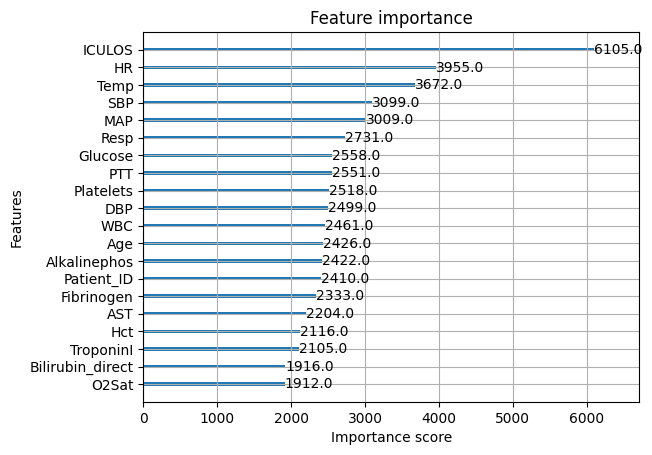

In [13]:
# Plot feature importance
xgb.plot_importance(model, importance_type="weight", max_num_features=20)


In [ ]:
## plot decision tree

# Plot the first tree (index 0) using the new `tree_idx` parameter
plt.figure(figsize=(60, 40))
plot_tree(model, tree_idx=3, rankdir='LR', num_trees=3)
plt.savefig("high_res_tree.png", dpi=1000)
plt.show()


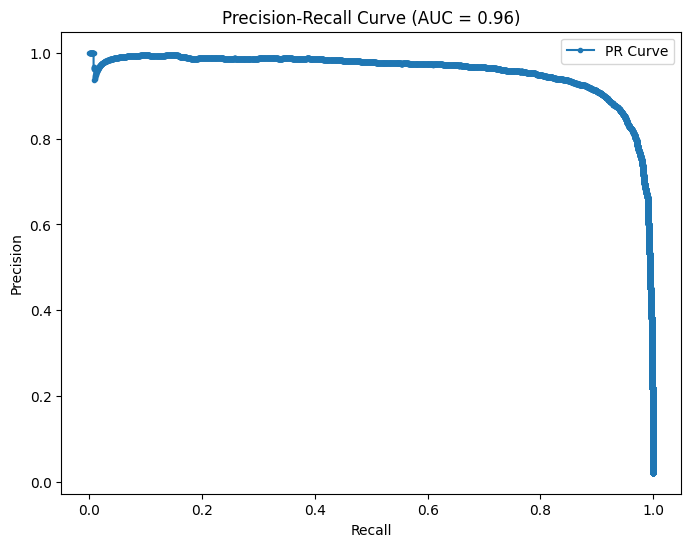

In [15]:
# precision recall curve
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
# Calculate the area under the PR curve
auc_score = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.legend()
plt.show()

# Feature Importance for HR

In [24]:

df = hospital_df.copy() 
target = "HR"
features = [col for col in df.columns if col != target]  # Use all columns except target

df[features] = df.groupby("Patient_ID")[features].ffill().bfill()
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # no stratify

model = XGBRegressor(max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")



MSE: 85.6629
R² Score: 0.7023


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

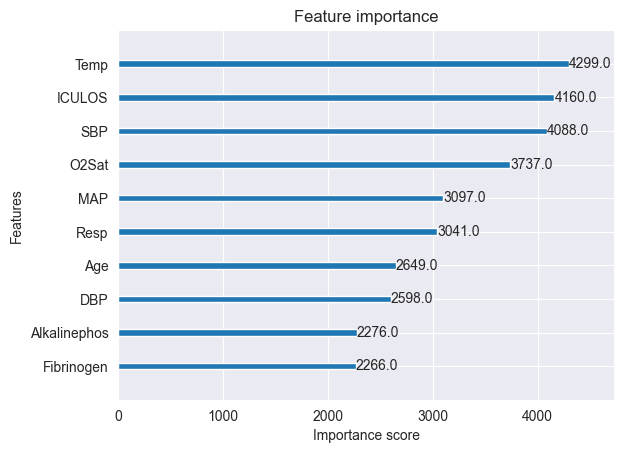

In [25]:
xgb.plot_importance(model, importance_type="weight", max_num_features=10)

# Feature Importance for O2Sat

In [26]:

df = hospital_df.copy() 
target = "O2Sat"
features = [col for col in df.columns if col != target]  # Use all columns except target

df[features] = df.groupby("Patient_ID")[features].ffill().bfill()
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # no stratify

model = XGBRegressor(max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")



MSE: 4.9402
R² Score: 0.4059


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

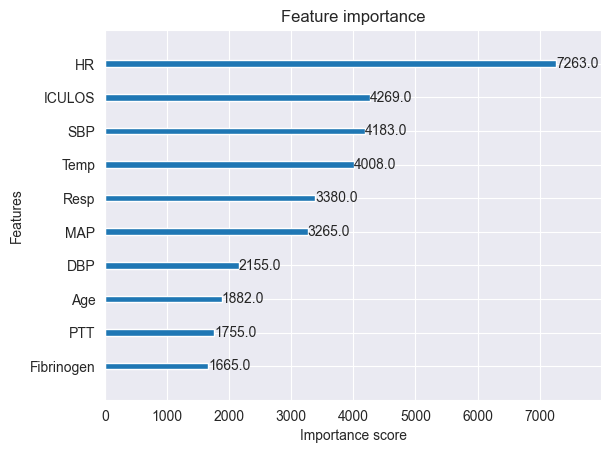

In [27]:
xgb.plot_importance(model, importance_type="weight", max_num_features=10)

# Feature Importance for SBP

In [28]:
df = hospital_df.copy() 
target = "SBP"
features = [col for col in df.columns if col != target]  # Use all columns except target

df[features] = df.groupby("Patient_ID")[features].ffill().bfill()
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # no stratify

model = XGBRegressor(max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 72.7229
R² Score: 0.8417


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

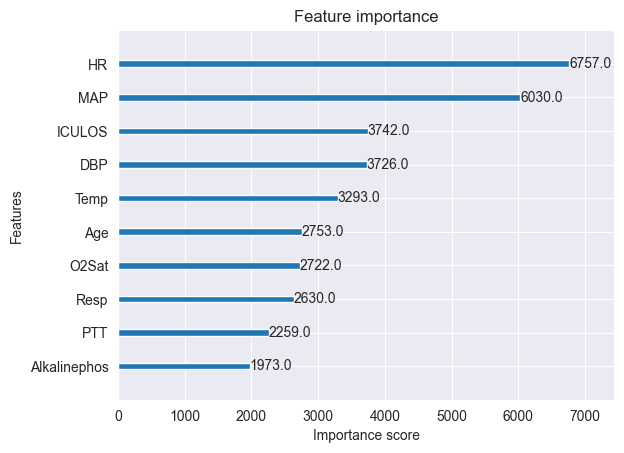

In [29]:
xgb.plot_importance(model, importance_type="weight", max_num_features=10)

# Feature Importance for MAP

In [32]:
df = hospital_df.copy() 
target = "MAP"
features = [col for col in df.columns if col != target]  # Use all columns except target

df[features] = df.groupby("Patient_ID")[features].ffill().bfill()
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # no stratify

model = XGBRegressor(max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 50.1871
R² Score: 0.7777


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

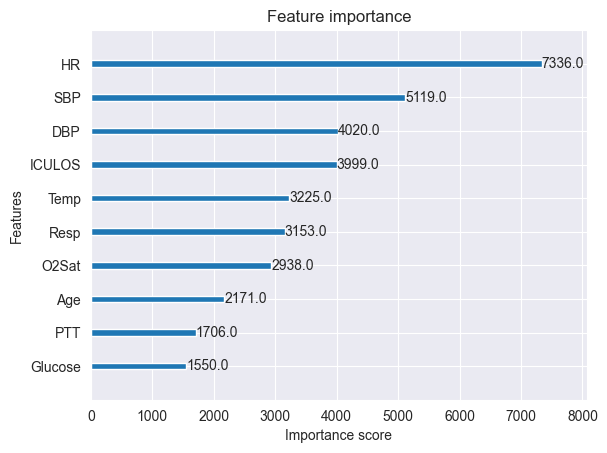

In [33]:
xgb.plot_importance(model, importance_type="weight", max_num_features=10)

# Feature Importance for DBP

In [34]:
df = hospital_df.copy() 
target = "MAP"
features = [col for col in df.columns if col != target]  # Use all columns except target

df[features] = df.groupby("Patient_ID")[features].ffill().bfill()
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # no stratify

model = XGBRegressor(max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 50.1871
R² Score: 0.7777


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

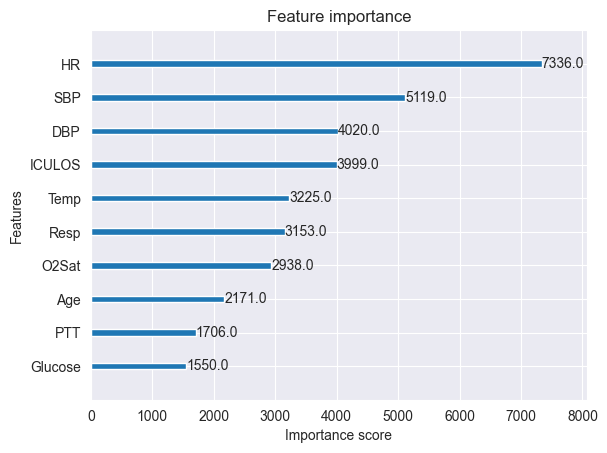

In [35]:
xgb.plot_importance(model, importance_type="weight", max_num_features=10)

# Feature Importance for Resp

In [36]:
df = hospital_df.copy() 
target = "Resp"
features = [col for col in df.columns if col != target]  # Use all columns except target

df[features] = df.groupby("Patient_ID")[features].ffill().bfill()
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # no stratify

model = XGBRegressor(max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 14.2557
R² Score: 0.5046


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

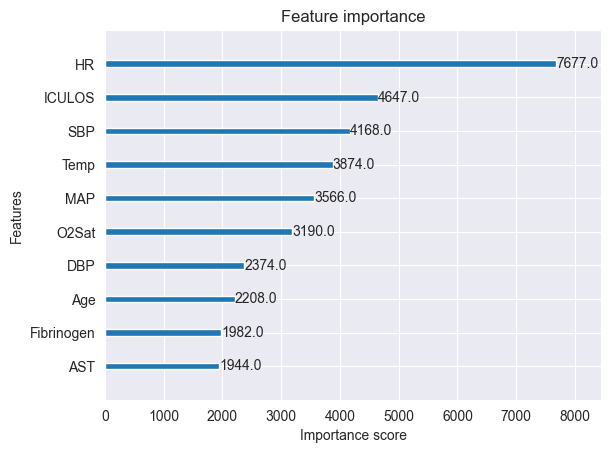

In [37]:
xgb.plot_importance(model, importance_type="weight", max_num_features=10)

# Feature Importance for Temp

In [50]:
df = hospital_df.copy() 
target = "Temp"
features = [col for col in df.columns if col != target]  # Use all columns except target

df[features] = df.groupby("Patient_ID")[features].ffill().bfill()
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # no stratify

model = XGBRegressor(max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 0.2603
R² Score: 0.5701


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

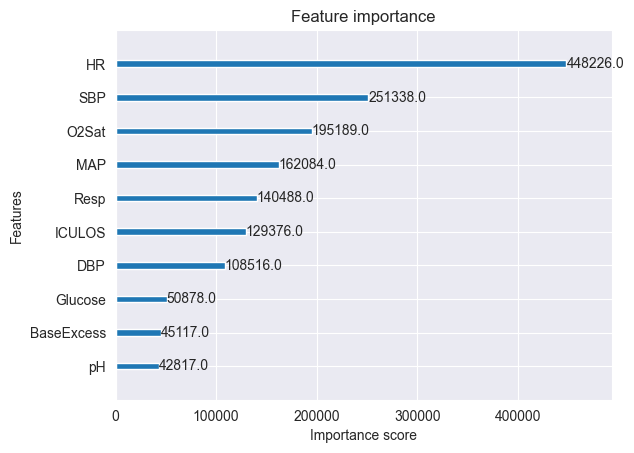

In [49]:
xgb.plot_importance(model, importance_type="weight", max_num_features=10)